In [120]:
# %% Impor Library
import numpy as np
import matplotlib.pyplot as plt
import math

In [121]:
# %% Fungsi Baca Data
def baca_data(file_path, start_time, end_time, bit=10):
    """Membaca file data dan return waktu dan nilai digital"""
    data = np.loadtxt(file_path)
    time = data[:, 0]
    vcp = data[:, 4]  # Ambil kolom VCP (kolom ke-5)
    vcn = data[:, 5]  # Ambil kolom VCN (kolom ke-6)
    ck = data[:, 1]  # Ambil kolom CKO (kolom ke-2)
    ck_bits = (ck >= 0.9).astype(int)  # Ambil bit CKO
    vc = vcp - vcn  # Hitung Vc dari VCP dan VCN

    # Pilih data dalam window waktu
    mask = (time >= start_time) & (time <= end_time)
    time_sel = time[mask]
    time_sel = time_sel - time_sel[0]  # Normalisasi waktu
    vc_sel = vc[mask]
    ck_sel = ck_bits[mask]

    ck_points = np.zeros(2**bit, dtype=int)  # Tempat untuk menyimpan titik CKO
    already = 0
    for i in range(1, len(ck_sel)-1):
        if ck_sel[i] == 0 and ck_sel[i+1] == 1 and already < 2**bit:
            ck_points[already] = i  # Ambil titik CKO
            already += 1
        elif already >= 2**bit:
            break

    # Take samples at every n points
    vc_sel_sampled = vc_sel[ck_points.astype(int)]
    time_sel_sampled = time_sel[ck_points.astype(int)]

    return time_sel_sampled, vc_sel_sampled

def compute_fft(time, signal):
    """Compute the FFT of a signal with windowing."""
    n = len(signal)
    # Apply Hanning window
    window = np.square(n)
    windowed_signal = signal * window
    
    fft_result = np.fft.fft(windowed_signal)
    fft_result = fft_result[:n//2]  # Take only the positive frequencies
    sampling_rate = 1 / (time[1] - time[0])  # Calculate sampling rate from time
    freqs = np.fft.fftfreq(len(signal), d=1/sampling_rate)[:n//2]
    power_spectrum = 20 * np.log10(np.abs(fft_result))
    power_ref = np.max(power_spectrum)
    mag = power_spectrum - power_ref  # Normalize to dB
    return freqs, mag

def compute_fft_placeholder(time, digital_signal, window_type='hann'):
    """
    Placeholder untuk fungsi compute_fft.
    Fungsi ini seharusnya mengembalikan sumbu frekuensi dan magnitudo FFT satu sisi dalam dB.
    Magnitudo FFT harus diskalakan dengan benar sehingga merepresentasikan amplitudo puncak.
    """
    N = len(digital_signal)
    if N == 0:
        return np.array([]), np.array([])

    # Terapkan windowing
    if window_type == 'hann':
        window = np.hanning(N)
    elif window_type == 'hamming':
        window = np.hamming(N)
    elif window_type == 'blackman':
        window = np.blackman(N)
    else: # 'rectangle' atau tidak ada window
        window = np.ones(N)
    
    digital_signal_windowed = digital_signal * window
    
    # Lakukan FFT
    fft_result = np.fft.fft(digital_signal_windowed)
    
    # Hitung spektrum satu sisi
    # Untuk sinyal real, FFT simetris, kita hanya butuh setengahnya
    fft_one_sided = fft_result[1 :N//2] 
    
    # Skala magnitudo
    # Skala dengan 2/N untuk mendapatkan amplitudo puncak (kecuali DC dan Nyquist)
    # Koheren gain dari window juga perlu diperhitungkan jika ingin akurasi tinggi.
    # Untuk Hann window, coherent gain (amplitude) adalah 0.5. Jadi, dibagi 0.5 (atau dikali 2).
    # Jika scaling FFT adalah 1/N, maka P_peak = |X(k)| * 2 / N.
    # Jika scaling FFT adalah 1, maka P_peak = |X(k)| * 2 / N.
    # np.fft.fft tidak melakukan normalisasi.
    
    fft_magnitude_peak = np.abs(fft_one_sided) * (2.0 / N)
    if N % 2 == 0: # Genap
        fft_magnitude_peak[0] = np.abs(fft_one_sided[0]) * (1.0 / N) # DC
        fft_magnitude_peak[-1] = np.abs(fft_one_sided[-1]) * (1.0 / N) # Nyquist
    else: # Ganjil
        fft_magnitude_peak[0] = np.abs(fft_one_sided[0]) * (1.0 / N) # DC
        
    # Konversi ke dB
    # Hindari log(0) dengan menambahkan nilai kecil atau menangani kasus nol
    epsilon = 1e-20  # Nilai kecil untuk menghindari log(0)
    fft_mag_db = 20 * np.log10(fft_magnitude_peak + epsilon)
    
    # Buat sumbu frekuensi
    sampling_rate = 1 / (time[1] - time[0]) if len(time) > 1 and (time[1] - time[0]) > 0 else 1.0
    freq_axis = np.fft.fftfreq(N, d=1/sampling_rate)[1 :N//2]
    
    return freq_axis, fft_mag_db

def calculate_adc_dynamic_parameters(freq_axis, fft_mag_db, num_harmonics_to_consider=5, signal_bw_bins=0):
    """
    Menghitung parameter dinamik ADC dari hasil FFT (dalam dB).

    Args:
        freq_axis (np.array): Array sumbu frekuensi.
        fft_mag_db (np.array): Array magnitudo FFT dalam dB.
        num_harmonics_to_consider (int): Jumlah harmonik yang akan dipertimbangkan untuk THD dan distorsi.
        signal_bw_bins (int): Jumlah bin di setiap sisi puncak fundamental/harmonik
                               untuk dipertimbangkan sebagai bagian dari dayanya (0 berarti hanya bin puncak).

    Returns:
        dict: Kamus berisi parameter dinamik ADC.
    """
    if len(fft_mag_db) == 0 or len(freq_axis) == 0:
        print("Error: fft_mag_db atau freq_axis kosong.")
        return None

    N_fft_half = len(fft_mag_db) # Panjang spektrum satu sisi (NFFT/2 + 1)

    results = {}

    # --- 1. Identifikasi Fundamental ---
    # Abaikan komponen DC (indeks 0) untuk pencarian fundamental
    if N_fft_half <= 1:
        print("Error: Spektrum FFT terlalu pendek untuk menemukan fundamental.")
        return None
        
    # Cari fundamental pada spektrum tanpa DC
    # fundamental_bin_in_slice = np.argmax(fft_mag_db[1:])
    # index_fundamental_0based = fundamental_bin_in_slice + 1
    
    # Lebih baik mencari di seluruh spektrum jika DC mungkin lebih tinggi dari sinyal lemah
    # Namun, umumnya fundamental adalah puncak tertinggi setelah DC.
    # Kita asumsikan fundamental adalah puncak terbesar setelah DC.
    search_range_for_fundamental = fft_mag_db[1:]
    if len(search_range_for_fundamental) == 0: # Jika hanya ada DC
        print("Error: Tidak ada frekuensi non-DC untuk mencari fundamental.")
        # Set nilai default atau error yang sesuai
        results['Error'] = "Tidak ada frekuensi non-DC"
        return results

    fundamental_bin_in_slice = np.argmax(search_range_for_fundamental)
    index_fundamental_0based = fundamental_bin_in_slice + 1


    A_fundamental_dB = fft_mag_db[index_fundamental_0based]
    f_fundamental_hz = freq_axis[index_fundamental_0based]
    results['Fundamental Frequency (Hz)'] = f_fundamental_hz
    results['Fundamental Amplitude (dB)'] = A_fundamental_dB

    # Helper untuk konversi dB ke daya linear
    # Untuk komponen AC: P_lin = (A_lin_peak^2) / 2 = (10^(A_dB/20))^2 / 2 = 10^(A_dB/10) / 2
    # Untuk komponen DC: P_lin_DC = A_lin_DC^2 = (10^(A_DC_dB/20))^2 = 10^(A_DC_dB/10)
    def db_amplitude_to_linear_power(db_val, is_dc=False):
        if db_val == -np.inf: # Amplitudo nol
            return 0.0
        if is_dc:
            return 10**(db_val / 10.0)
        else:
            return (10**(db_val / 10.0)) / 2.0

    # --- 2. Hitung Daya Sinyal (Fundamental) ---
    P_S_linear = 0
    # Jendela untuk daya fundamental
    start_bin_S = max(0, index_fundamental_0based - signal_bw_bins)
    end_bin_S = min(N_fft_half - 1, index_fundamental_0based + signal_bw_bins)
    for k_s in range(start_bin_S, end_bin_S + 1):
        # Pastikan bin ini tidak DC kecuali fundamental itu sendiri adalah DC (jarang untuk ADC test)
        is_dc_component = (k_s == 0)
        P_S_linear += db_amplitude_to_linear_power(fft_mag_db[k_s], is_dc=is_dc_component)
    
    results['Signal Power (P_S) linear'] = P_S_linear
    if P_S_linear <= 0: # Untuk menghindari log(0)
        results['Signal Power (P_S) dB'] = -np.inf
    else:
        results['Signal Power (P_S) dB'] = 10 * np.log10(P_S_linear)


    # --- 3. Identifikasi Harmonik dan Hitung Daya Distorsi (Harmonik) ---
    P_D_total_linear = 0
    harmonics_details = []
    # Buat set untuk menyimpan semua bin yang terkait dengan fundamental atau harmonik
    signal_and_harmonic_bins = set(range(start_bin_S, end_bin_S + 1))

    for h in range(2, num_harmonics_to_consider + 1):
        f_harmonic_target = h * f_fundamental_hz
        if f_harmonic_target >= freq_axis[-1]: # Jika harmonik di luar jangkauan frekuensi
            harmonics_details.append({
                'harmonic_order': h, 
                'target_freq_hz': f_harmonic_target, 
                'status': 'Di luar Fs/2',
                'amplitude_db': -np.inf,
                'power_linear': 0.0
            })
            continue

        # Cari bin terdekat untuk harmonik
        index_harmonic_0based = np.argmin(np.abs(freq_axis - f_harmonic_target))
        
        # Pastikan bin harmonik tidak tumpang tindih dengan fundamental
        # Ini adalah penyederhanaan; deteksi harmonik yang robust bisa lebih kompleks
        is_overlapping_fundamental = False
        temp_harmonic_bins = set()
        start_bin_H = max(0, index_harmonic_0based - signal_bw_bins)
        end_bin_H = min(N_fft_half - 1, index_harmonic_0based + signal_bw_bins)

        for k_h_check in range(start_bin_H, end_bin_H + 1):
            if k_h_check in range(start_bin_S, end_bin_S + 1): # Cek overlap dengan jendela fundamental
                is_overlapping_fundamental = True
                break
            temp_harmonic_bins.add(k_h_check)

        if is_overlapping_fundamental:
            harmonics_details.append({
                'harmonic_order': h, 
                'target_freq_hz': f_harmonic_target, 
                'found_freq_hz': freq_axis[index_harmonic_0based],
                'status': 'Tumpang tindih dengan fundamental',
                'amplitude_db': -np.inf, # Dianggap tidak terukur jika tumpang tindih
                'power_linear': 0.0
            })
            continue # Abaikan harmonik ini jika tumpang tindih dengan fundamental

        A_harmonic_dB = fft_mag_db[index_harmonic_0based] # Ambil puncak bin harmonik
        P_H_linear_current = 0
        for k_h in range(start_bin_H, end_bin_H + 1):
            # Harmonik selalu AC, jadi is_dc=False
            P_H_linear_current += db_amplitude_to_linear_power(fft_mag_db[k_h], is_dc=False)
            signal_and_harmonic_bins.add(k_h) # Tambahkan bin harmonik ke set
            
        P_D_total_linear += P_H_linear_current
        harmonics_details.append({
            'harmonic_order': h,
            'target_freq_hz': f_harmonic_target,
            'found_freq_hz': freq_axis[index_harmonic_0based],
            'bin_index': index_harmonic_0based,
            'amplitude_db': A_harmonic_dB, # Amplitudo puncak dari bin harmonik
            'power_linear': P_H_linear_current
        })
        
    results['Harmonics Details'] = harmonics_details
    results['Total Distortion Power (P_D) linear'] = P_D_total_linear

    # --- 4. Hitung Daya Noise ---
    # Daya noise adalah total daya dari semua bin KECUALI DC, fundamental, dan harmonik.
    P_N_linear = 0
    # Indeks bin DC adalah 0
    dc_bin_index = 0
    
    for k in range(N_fft_half): # Loop melalui semua bin di spektrum satu sisi
        if k == dc_bin_index: # Lewati DC untuk perhitungan noise floor standar
            continue
        if k in signal_and_harmonic_bins: # Lewati jika bin ini adalah bagian dari sinyal atau harmonik
            continue
        
        # Semua yang tersisa dianggap noise (dan spur non-harmonik)
        P_N_linear += db_amplitude_to_linear_power(fft_mag_db[k], is_dc=False) # Noise selalu AC
        
    results['Noise Power (P_N) linear'] = P_N_linear

    # --- 5. Hitung Parameter Kinerja ---
    # SNR (Signal-to-Noise Ratio)
    if P_N_linear <= 0 or P_S_linear <= 0:
        SNR_dB = -np.inf if P_S_linear > 0 else (np.inf if P_N_linear == 0 and P_S_linear == 0 else -np.inf) # Handle P_N=0
    else:
        SNR_dB = 10 * np.log10(P_S_linear / P_N_linear)
    results['SNR (dB)'] = SNR_dB

    # THD (Total Harmonic Distortion)
    # THD_ratio_power = P_D_total_linear / P_S_linear
    # THD_dB = 10 * log10(THD_ratio_power)
    if P_S_linear <= 0 or P_D_total_linear < 0: # P_D bisa 0
        THD_dB = -np.inf # Tidak ada sinyal atau tidak ada distorsi terukur
        THD_ratio = 0.0
    elif P_D_total_linear == 0: # Tidak ada distorsi
        THD_dB = -np.inf # Atau bisa didefinisikan sebagai sangat kecil
        THD_ratio = 0.0
    else:
        THD_ratio_power = P_D_total_linear / P_S_linear
        THD_dB = 10 * np.log10(THD_ratio_power)
        # THD juga sering didefinisikan sebagai rasio amplitudo RMS: sqrt(sum(A_h_rms^2)) / A_s_rms
        # Jika A_rms = A_peak / sqrt(2), maka P = A_rms^2. Jadi P_h / P_s = (A_h_rms^2) / (A_s_rms^2)
        # THD_amp_ratio = sqrt(P_D_total_linear / P_S_linear)
        THD_ratio = math.sqrt(THD_ratio_power) # Rasio amplitudo RMS

    results['THD (dB)'] = THD_dB
    results['THD Ratio (RMS Amp)'] = THD_ratio

    # SINAD (Signal-to-Noise and Distortion Ratio)
    P_ND_linear = P_N_linear + P_D_total_linear # Noise + Distortion power
    if P_ND_linear <= 0 or P_S_linear <= 0:
        SINAD_dB = -np.inf if P_S_linear > 0 else (np.inf if P_ND_linear == 0 and P_S_linear == 0 else -np.inf)
    else:
        SINAD_dB = 10 * np.log10(P_S_linear / P_ND_linear)
    results['SINAD (dB)'] = SINAD_dB

    # ENOB (Effective Number of Bits)
    if SINAD_dB == -np.inf or SINAD_dB == np.inf :
         ENOB = 0.0 if SINAD_dB == -np.inf else float('inf') # Kasus ideal jika SINAD tak hingga
    else:
        ENOB = (SINAD_dB - 1.76) / 6.02
    results['ENOB (bits)'] = ENOB
    
    # SFDR (Spurious-Free Dynamic Range)
    # SFDR adalah rasio amplitudo fundamental terhadap amplitudo spur terbesar.
    # Spur terbesar bisa jadi harmonik atau non-harmonik.
    # Kita cari puncak tertinggi di luar fundamental dan DC.
    
    fft_mag_for_sfdr = np.copy(fft_mag_db)
    # Nol-kan (set ke dB sangat rendah) fundamental dan DC untuk mencari spur
    fft_mag_for_sfdr[dc_bin_index] = -np.inf 
    for k_s_sfdr in range(start_bin_S, end_bin_S + 1): # Nolkan jendela fundamental
         if 0 <= k_s_sfdr < len(fft_mag_for_sfdr):
            fft_mag_for_sfdr[k_s_sfdr] = -np.inf
            
    # Jika definisi SFDR mengecualikan harmonik, maka nol-kan juga harmonik.
    # Umumnya, SFDR menyertakan harmonik sebagai kandidat spur.
    # for h_detail in harmonics_details:
    # if h_detail.get('bin_index') is not None and h_detail['power_linear'] > 0:
    # idx_h_sfdr = h_detail['bin_index']
    # start_h_sfdr = max(0, idx_h_sfdr - signal_bw_bins)
    # end_h_sfdr = min(N_fft_half - 1, idx_h_sfdr + signal_bw_bins)
    # for k_h_sfdr in range(start_h_sfdr, end_h_sfdr + 1):
    # if 0 <= k_h_sfdr < len(fft_mag_for_sfdr):
    # fft_mag_for_sfdr[k_h_sfdr] = -np.inf
            
    if len(fft_mag_for_sfdr[1:]) > 0 : # Pastikan ada sesuatu untuk dicari max selain DC
        A_spur_max_dB = np.max(fft_mag_for_sfdr[1:]) # Cari spur di luar DC
        # Jika semua -np.inf, A_spur_max_dB akan -np.inf
    else:
        A_spur_max_dB = -np.inf

    if A_spur_max_dB == -np.inf or A_fundamental_dB == -np.inf:
        SFDR_dB = np.inf # Tidak ada spur atau tidak ada fundamental
    else:
        SFDR_dB = A_fundamental_dB - A_spur_max_dB
    results['SFDR (dBc)'] = SFDR_dB # dBc karena relatif terhadap fundamental

    return results

In [122]:
# %% Parameter Input
# File and ADC Configuration
file_path = "/home/mthudaa/.xschem/simulations/th_tb.txt"    # Data file path
bit = 10                            # ADC resolution (bits)
nbpt = 2**bit                      # Number of FFT points (power of 2)

# Timing Parameters
start_time = 0.39e-6               # Start time for analysis (seconds)
sampling_period = 0.52e-6          # Sampling period (seconds)
fs_param = 1/sampling_period      # Sampling frequency (Hz)
duration = nbpt/fs_param          # Signal duration (seconds)
end_time = start_time + duration  # End time for analysis (seconds)

# Frequency Analysis Parameters
fin_ratio = 0.1                   # Input frequency ratio to sampling frequency
fin = (round(fin_ratio * nbpt)/nbpt) * fs_param  # Input frequency (Hz)
num_harmonics = 10                # Number of harmonics to analyze

# Print Parameter Values
print("=== Configuration Parameters ===")
print(f"File Path: {file_path}")
print(f"ADC Resolution: {bit} bits")
print(f"Number of FFT Points: {nbpt}")
print("\n=== Timing Parameters ===")
print(f"Start Time: {start_time*1e6:.2f} µs")
print(f"Sampling Period: {sampling_period*1e6:.2f} µs")
print(f"Sampling Frequency: {fs_param/1e3:.2f} kHz")
print(f"Duration: {duration*1e3:.2f} ms")
print(f"End Time: {end_time*1e6:.2f} µs")
print("\n=== Frequency Analysis Parameters ===")
print(f"Input Frequency Ratio: {fin_ratio}")
print(f"Input Frequency: {fin/1e3:.2f} kHz")
print(f"Number of Harmonics: {num_harmonics}")

=== Configuration Parameters ===
File Path: /home/mthudaa/.xschem/simulations/th_tb.txt
ADC Resolution: 10 bits
Number of FFT Points: 1024

=== Timing Parameters ===
Start Time: 0.39 µs
Sampling Period: 0.52 µs
Sampling Frequency: 1923.08 kHz
Duration: 0.53 ms
End Time: 532.87 µs

=== Frequency Analysis Parameters ===
Input Frequency Ratio: 0.1
Input Frequency: 191.56 kHz
Number of Harmonics: 10


In [123]:
time, vc = baca_data(file_path, start_time, end_time, bit)
time.shape, vc.shape

((1024,), (1024,))

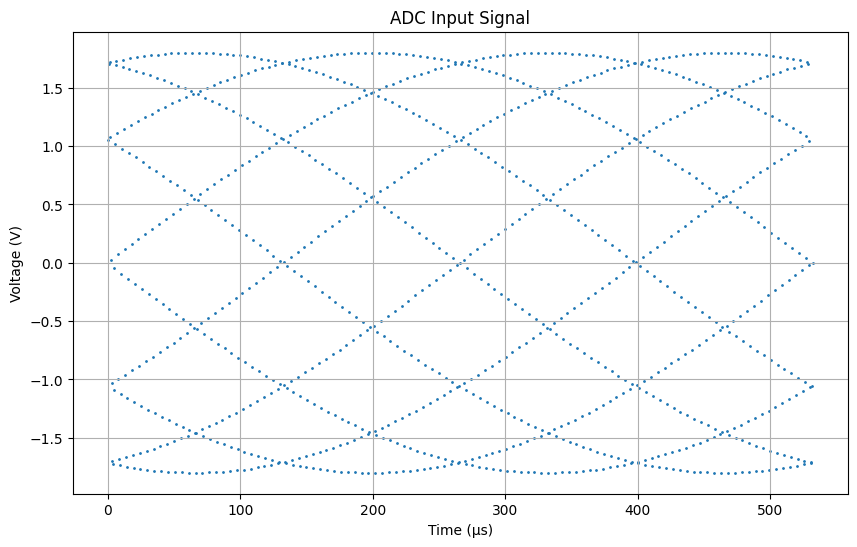

In [124]:
plt.figure(figsize=(10, 6))
plt.scatter(time*1e6, vc, s=1)
plt.grid(True)
plt.xlabel('Time (µs)')
plt.ylabel('Voltage (V)')
plt.title('ADC Input Signal')
plt.show()

In [125]:
freq, fft_mag = compute_fft_placeholder(time, vc, window_type='square')
adc_params = calculate_adc_dynamic_parameters(freq, fft_mag, num_harmonics_to_consider=10, signal_bw_bins=1)

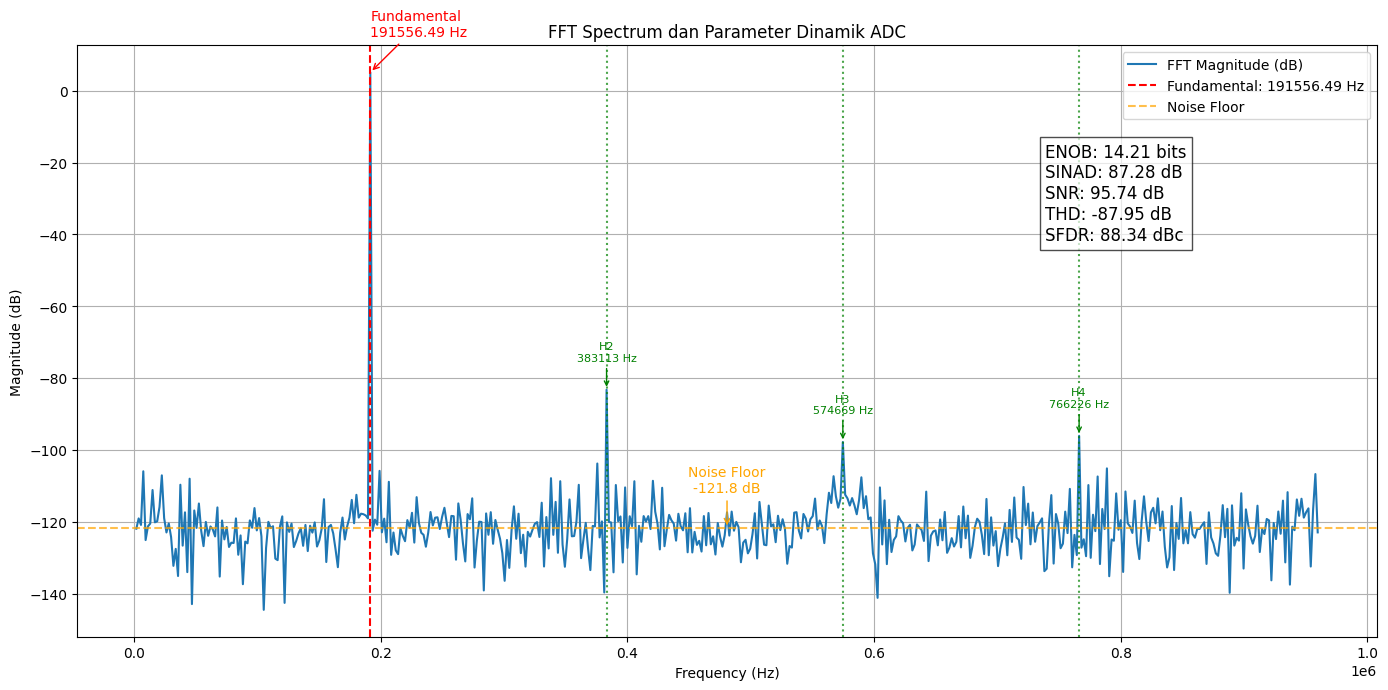

In [126]:
# Plot FFT dan parameter dinamik ADC

plt.figure(figsize=(14, 7))
plt.plot(freq, fft_mag, label='FFT Magnitude (dB)')
plt.title('FFT Spectrum dan Parameter Dinamik ADC')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)

# Tandai fundamental
if 'Fundamental Frequency (Hz)' in adc_params:
    f_fund = adc_params['Fundamental Frequency (Hz)']
    a_fund = adc_params['Fundamental Amplitude (dB)']
    plt.axvline(f_fund, color='r', linestyle='--', label=f'Fundamental: {f_fund:.2f} Hz')
    plt.annotate(f'Fundamental\n{f_fund:.2f} Hz',
                 xy=(f_fund, a_fund),
                 xytext=(f_fund, a_fund+10),
                 arrowprops=dict(arrowstyle='->', color='red'),
                 color='red')

# Tandai harmonik
if 'Harmonics Details' in adc_params:
    for h in adc_params['Harmonics Details']:
        # Hanya anotasi harmonik yang valid (tidak di luar Fs/2 dan tidak tumpang tindih)
        if h.get('status', '') not in ['Di luar Fs/2', 'Tumpang tindih dengan fundamental'] and h.get('amplitude_db', -np.inf) > -100:
            plt.axvline(h['found_freq_hz'], color='g', linestyle=':', alpha=0.7)
            plt.annotate(f"H{h['harmonic_order']}\n{h['found_freq_hz']:.0f} Hz",
                         xy=(h['found_freq_hz'], h['amplitude_db']),
                         xytext=(h['found_freq_hz'], h['amplitude_db']+8),
                         color='green',
                         fontsize=8,
                         ha='center',
                         arrowprops=dict(arrowstyle='->', color='green', lw=1))

# Anotasi noise floor (menggunakan median atau mean dari fft_mag)
noise_floor = np.median(fft_mag)
plt.axhline(noise_floor, color='orange', linestyle='--', alpha=0.7, label='Noise Floor')
plt.annotate(f'Noise Floor\n{noise_floor:.1f} dB',
             xy=(freq[len(freq)//2], noise_floor),
             xytext=(freq[len(freq)//2], noise_floor+10),
             color='orange',
             fontsize=10,
             ha='center',
             arrowprops=dict(arrowstyle='->', color='orange', lw=1))

plt.legend(loc='upper right')

# Tampilkan parameter dinamik ADC di plot
param_text = (
    f"ENOB: {adc_params.get('ENOB (bits)', 0):.2f} bits\n"
    f"SINAD: {adc_params.get('SINAD (dB)', 0):.2f} dB\n"
    f"SNR: {adc_params.get('SNR (dB)', 0):.2f} dB\n"
    f"THD: {adc_params.get('THD (dB)', 0):.2f} dB\n"
    f"SFDR: {adc_params.get('SFDR (dBc)', 0):.2f} dBc"
)
plt.gcf().text(0.75, 0.65, param_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()